In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import spacy_langdetect
from hashlib import sha256
import string
from wordcloud import WordCloud
from tqdm import tqdm
import seaborn as sns

# Removing non-English words
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector

# Kullback-Leibler Divergence
from collections import Counter
from scipy.stats import entropy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import euclidean_distances

# Bigrams and Trigrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# LDA
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
from gensim.models import LdaMulticore
import pyLDAvis
import pyLDAvis.gensim

# Parallel Processing
from joblib import Parallel, delayed
import multiprocessing

In [2]:
nlp_model = spacy.load('en_core_web_md')

/opt/anaconda3/envs/nlp2024/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<div style="background-color:#2C2E4F ; padding: 20px 0;">
    <center><h1 style="color:#E5E5E5; font-weight:bold; font-size:35px ">LOAD THE DATA</h1></center>
</div>

In [4]:
df_rep = pd.read_csv('09-2021_dbRep.csv', usecols=lambda x: not x.startswith('Unnamed'))

<div style="background-color:#2C2E4F ; padding: 20px 0;">
    <center><h1 style="color:#E5E5E5; font-weight:bold; font-size:35px ">INITIAL EXPLORATION AND ADJUSTMENT</h1></center>
</div>

In [5]:
# Limit role to students only
df_rep = df_rep[df_rep['metadata_context_role'] == 'StudentEnrollment']
df_rep['metadata_context_role'].value_counts()

metadata_context_role
StudentEnrollment    135598
Name: count, dtype: int64

<div style='border:2px solid #2C2E4F; padding:15px'>
    Only student roles were considered for topic modeling.
</div>

<div style="background-color:#39C5A2 ; padding: 10px 0;">
    <center><h3 style="color:#2C2E4F; font-weight:bold; font-size:25px ">Remove rows with no texts</h3></center>
</div>

In [6]:
# There are rows with no texts
df_rep[df_rep['body_text'].isna()]

# Remove rows with no texts
df_rep = df_rep.dropna(subset='body_text', how='any')

In [7]:
# Sanity check
df_rep[df_rep['body_text'].isna()]

,collected_at,metadata_event_time,metadata_event_name,metadata_context_id,metadata_context_role,metadata_user_id,body_assignment_id,body_discussion_topic_id,body_discussion_entry_id,body_submission_id,body_user_id,body_parent_discussion_entry_id,body_text


<div style="background-color:#39C5A2 ; padding: 10px 0;">
    <center><h3 style="color:#2C2E4F; font-weight:bold; font-size:25px ">Remove rows with duplicate texts</h3></center>
</div>

In [8]:
# There are duplicate rows
df_rep[df_rep['body_text'].duplicated()]

# Remove the duplicates
df_rep = df_rep.drop_duplicates(subset='body_text', keep='first')

# # Sanity check
df_rep[df_rep['body_text'].duplicated()]

,collected_at,metadata_event_time,metadata_event_name,metadata_context_id,metadata_context_role,metadata_user_id,body_assignment_id,body_discussion_topic_id,body_discussion_entry_id,body_submission_id,body_user_id,body_parent_discussion_entry_id,body_text


<div style="background-color:#39C5A2 ; padding: 10px 0;">
    <center><h3 style="color:#2C2E4F; font-weight:bold; font-size:25px ">Remove non-English texts</h3></center>
</div>

In [9]:
def get_lang_detector(nlp, name):
    """
    Initialize a custom language detector for the given spaCy pipeline.

    This function creates a language detector using a fixed seed value to
    ensure reproducibility. It is designed to be used as a factory function
    within the spaCy pipeline.

    Parameters
    ----------
    nlp : spacy.language.Language
        The spaCy language pipeline object.
    name : str
        The name of the language detector component.

    Returns
    -------
    LanguageDetector
        An instance of LanguageDetector initialized with a fixed seed.
    """
    return LanguageDetector(seed=42)
    
Language.factory('language_detector', func=get_lang_detector)
nlp_model.add_pipe('language_detector', last=True)

In [10]:
def is_english(text, confidence=0.95):
    """
    Detect and extract English sentences from the given text based on language
    detection confidence.

    This function uses a pre-loaded spaCy model to process the input text and
    checks the detected language for each sentence. It returns sentences
    identified as English with a confidence score greater than or equal to the
    specified threshold.

    Parameters
    ----------
    text : str
        The input text to analyze.
    confidence : float, optional
        The minimum confidence score for a sentence to be considered English, 
        by default 0.95.

    Returns
    -------
    list of str
        A list of English sentences that meet the confidence threshold.
    """
    doc = nlp_model(text)
    sents = list(doc.sents)
    english_texts = []
    for sent in sents:
        # print(f"<BOS>{sent}<EOS>")
        language = sent._.language
        if (language['language'] == 'en') and (language['score'] >= confidence):
            english_texts.append(sent.text)
    # print(english_texts)
    return english_texts # should have been list(set(english_texts))

In [ ]:
# This might take a while. It's suggested not to run this again.
spacy.prefer_gpu()
tqdm.pandas(desc="Extracting English sentences")
df_rep['sentences'] = df_rep['body_text'].progress_apply(is_english)
df_rep_english = df_rep[~df_rep['sentences'].apply(lambda x: len(x) == 0)]

In [ ]:
def flatten_and_join(sentences):
    """
    Flatten a list of lists and join the elements into a single string.

    This function checks if the input is a list. If it's a list of lists, 
    it flattens it and joins the elements into a single string, with each
    element separated by a space. If the input is not a list, it returns an
    empty string.

    Parameters
    ----------
    sentences : list
        A list of sentences, which can be either a list of strings or a list
        of lists of strings.

    Returns
    -------
    str
        A single string formed by joining all the elements in the list.

    Example
    -------
    flat_text = flatten_and_join([["Hello", "world"], ["This", "is", "a",
    "test"]])
    # Output: "Hello world This is a test"
    """
    if isinstance(sentences, list):
        # Flatten the list if it is a list of lists
        flat_list = [item for sublist in sentences for item in
                     (sublist if isinstance(sublist, list) else [sublist])]
        return ' '.join(flat_list)
    return ''

df_rep_english['sentences_joined'] = (df_rep_english['sentences']
                                      .apply(flatten_and_join))

<div style="background-color:#39C5A2 ; padding: 10px 0;">
    <center><h3 style="color:#2C2E4F; font-weight:bold; font-size:25px ">Investigate Token Distribution</h3></center>
</div>

In [12]:
df_rep_english = pd.read_csv('df_english.csv',
                             usecols=lambda x: 'Unnamed' not in x)

/opt/anaconda3/envs/nlp2024/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/envs/nlp2024/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/opt/anaconda3/envs/nlp2024/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


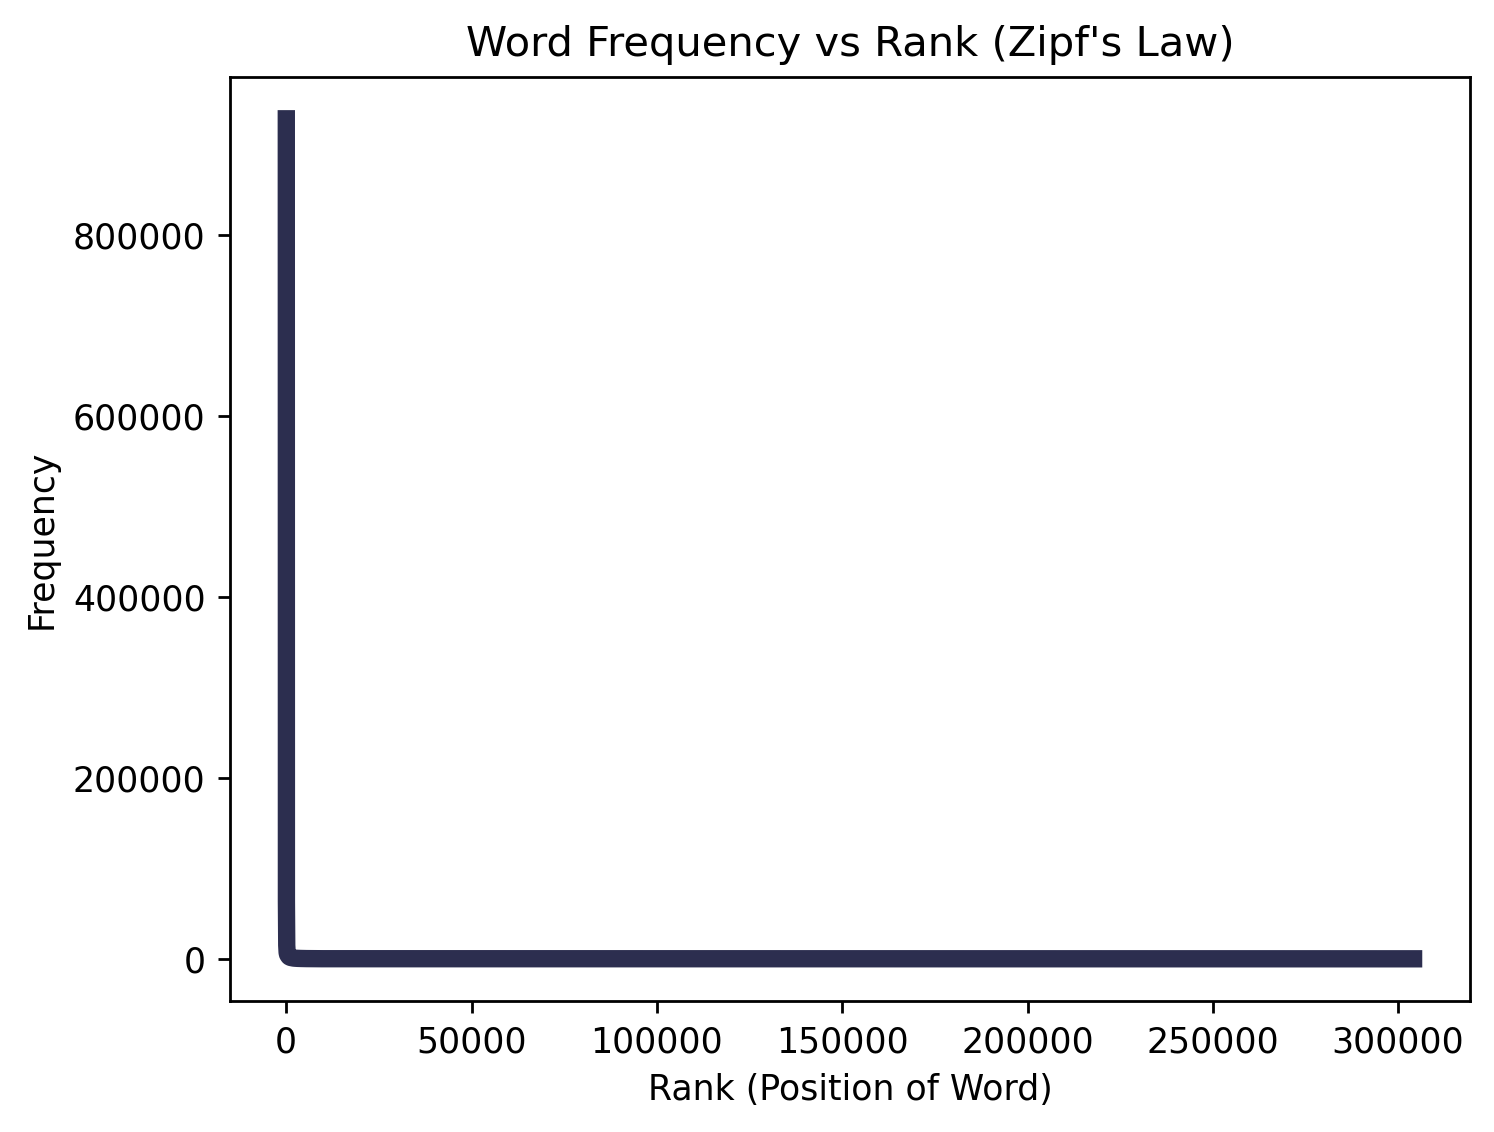

<Figure size 640x480 with 0 Axes>

In [14]:
# Count word frequencies in your preprocessed text
word_counts = Counter(" ".join(df_rep_english['sentences_joined']).split())

# Sort words by their frequency (from most frequent to least frequent)
sorted_word_counts = sorted(word_counts.values(), reverse=True)

# Plot the word frequency vs rank (no log-log transformation)
plt.figure(dpi=250)
plt.plot(range(1, len(sorted_word_counts) + 1), sorted_word_counts,
         linewidth=5, color='#2C2E4F'         
        )
plt.xlabel('Rank (Position of Word)')
plt.ylabel('Frequency')
plt.title('Word Frequency vs Rank (Zipf\'s Law)')
plt.show()
plt.savefig('zipf.png', dpi=250)

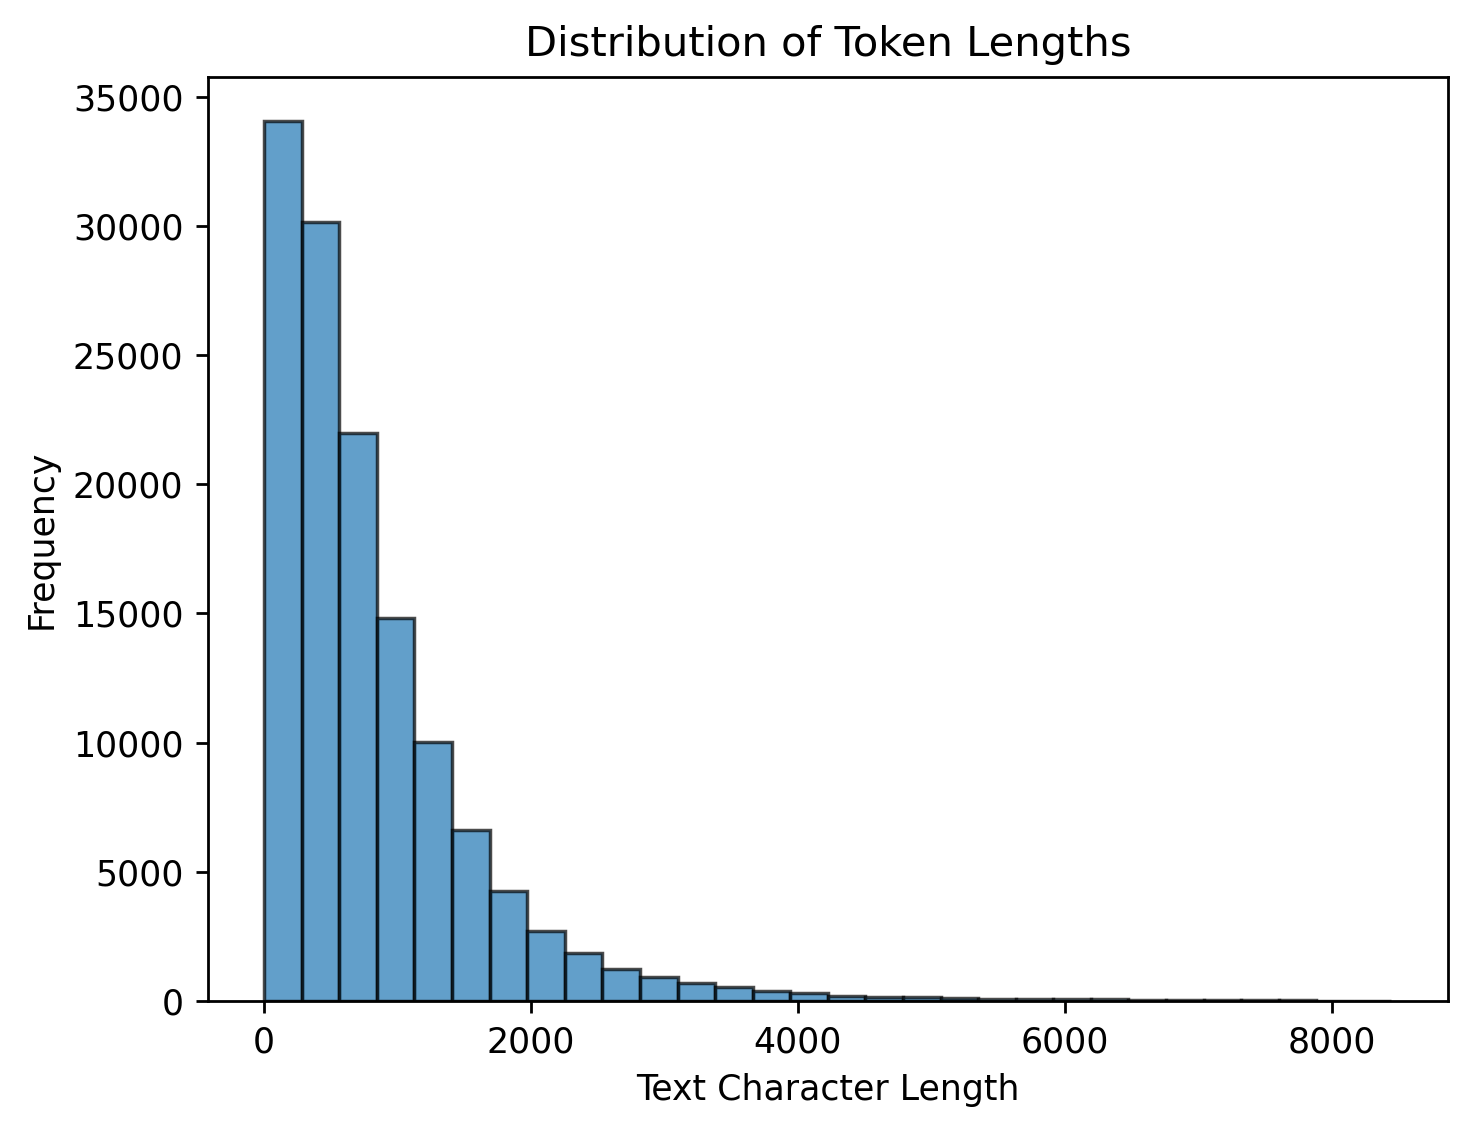

In [29]:
df_rep_len = df_rep_english['body_text'].str.len()
plt.figure(dpi=250)
plt.hist(df_rep_len, bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('Text Character Length')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.show()

<div style='border:2px solid #2C2E4F; padding:15px'>
    This visualization shows us that text length follows a distribution where a small number of texts are much longer than the rest, reflecting a pattern similar to Zipf's Law. Just as a few words dominate in terms of frequency, we see that most texts are relatively short, while a few extend significantly in length. Understanding this distribution is important for later stages, where removing outliers in the token space can be optimized using methods like Kullback-Leibler divergence.
</div>

<div style="background-color:#2C2E4F ; padding: 20px 0;">
    <center><h1 style="color:#E5E5E5; font-weight:bold; font-size:35px ">DATA PREPROCESSING</h1></center>
</div>

<div style="background-color:#39C5A2 ; padding: 10px 0;">
    <center><h3 style="color:#2C2E4F; font-weight:bold; font-size:25px ">Remove unnecessary characters</h3></center>
</div>

In [30]:
# 1: Remove stopwords, punctuation, emails, numbers, and URLs
def remove_unnecessary_tokens(text):
    """
    Remove stopwords, punctuation, emails, numbers, and URLs from the input
    text.

    Parameters
    ----------
    text : str
        The input string to be cleaned.

    Returns
    -------
    str
        A string with stopwords, punctuation, emails, numbers, and URLs
        removed.
    """
    # Tokenize
    doc = nlp_model(text)

    # Remove stopwords, punctuation, spaces, emails, numbers, and URLs
    filtered_tokens = [token.lemma_ for token in doc
                      if token.text not in nlp_model.Defaults.stop_words and
                      not token.is_punct and not token.is_space and
                      not token.like_email and not token.like_num and
                      not token.like_url
                     ]
    return ' '.join(filtered_tokens)


# 2: Function for finding alphanumeric characters in one string
def is_alphanumeric(token):
    """
    Check if a token contains both alphabetic characters and digits.

    Parameters
    ----------
    token : spacy.tokens.Token
        The token to be checked.

    Returns
    -------
    bool
        True if the token contains both alphabetic characters and digits,
        otherwise False.
    """
    return any(char.isdigit() for char in token.text) and any(char.isalpha()
                                                              for char in 
                                                              token.text)


# 3: Removing alphanumeric strings using (2)
def remove_alphanumeric(text):
    """
    Remove alphanumeric tokens from the input text.

    Parameters
    ----------
    text : str
        The input string to be cleaned.

    Returns
    -------
    str
        A string with alphanumeric tokens removed.
    """
    doc = nlp_model(text)

    # Filter out alphanumeric tokens
    filtered_tokens = [token.text
                       for token in doc if not is_alphanumeric(token)]

    return ' '.join(filtered_tokens)

# 4: Deduplication of adjacent duplicate tokens
def remove_consecutive_duplicates(text):
    """
    Remove consecutive duplicate tokens from the input text.

    Parameters
    ----------
    text : str
        The input string to be cleaned.

    Returns
    -------
    str
        A string with consecutive duplicate tokens removed.
    """
    tokens = text.split()
    filtered_tokens = []
    for i, token in enumerate(tokens):
        if i == 0 or token != tokens[i-1]:
            filtered_tokens.append(token)

    return ' '.join(filtered_tokens)
    

# 5: Sequential function
def clean_text(text):
    """
    Clean the input text by removing unnecessary tokens, alphanumeric strings,
    and consecutive duplicates.

    Parameters
    ----------
    text : str
        The input string to be cleaned.

    Returns
    -------
    str
        The cleaned text after applying all the preprocessing steps.
    """
    # Function for removing stopwords, punctuations, etc.
    cleaned_text = remove_unnecessary_tokens(text)

    # Function for removing alphanumeric strings
    cleaned_text = remove_alphanumeric(cleaned_text)

    # Function for removing consecutive duplicate tokens
    final_cleaned_text = remove_consecutive_duplicates(cleaned_text)

    return final_cleaned_text

In [ ]:
# I suggest not to run this again. Takes a while. Use df_preprocessed instead
spacy.prefer_gpu()
tqdm.pandas(desc='Preprocessing English Sentences')
df_rep_english['preprocessed_text'] = (df_rep_english['sentences_joined']
                                       .progress_apply(clean_text))
# df_rep_english.to_csv('df_preprocessed.csv', index=False)

<div style="background-color:#39C5A2 ; padding: 10px 0;">
    <center><h3 style="color:#2C2E4F; font-weight:bold; font-size:25px ">Heuristic Filtering in the Token Space</h3></center>
</div>

<div style='border:2px solid #2C2E4F; padding:15px'>
    Kullback-Leibler divergence (KL divergence) measures how one probability distribution differs from a reference distribution. In the context of topic modeling, KL divergence can be used to assess differences between token distributions in various documents or topics. This helps in identifying and addressing discrepancies in token usage, improving the quality and relevance of topic modeling outcomes.
</div>

In [33]:
df_rep_english = pd.read_csv('df_preprocessed.csv')

<div style='border:2px solid #2C2E4F; padding:15px'>
    Ideally, we should analyze at least 80% of the topic IDs, but due to computational constraints, we only analyzed the top 10% of the topics. Focusing on this subset not only makes the analysis more manageable but also improves interpretability. By concentrating on the most prominent topics, we can more easily identify and understand the key themes and patterns in the data.
</div>

In [35]:
topic_counts = df_rep_english['body_discussion_topic_id'].value_counts()
top_10_perc_count = int(len(topic_counts) * 0.10)
top_10_perc_topics = topic_counts.head(top_10_perc_count).index
top_10_perc_topics

df_top10 = df_rep_english[df_rep_english['body_discussion_topic_id'].isin(top_10_perc_topics)]

<div style="background-color:#FFDE58 ; padding: 10px 0;">
    <center><h5 style="color:#2C2E4F; font-weight:bold; font-size:15px ">Compute the token distribution for the corpus</h5></center>
</div>

In [36]:
# token distribution using CountVectorizer
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_top10['preprocessed_text']).toarray()

# initialize empty array for the corpus token counts
corpus_token_counts = np.zeros(X.shape[1])

# to sum the rows in parallel
def sum_row(row):
    """
    Return the input row as is.

    Parameters
    ----------
    row : any type
        The input row that will be returned without modification.

    Returns
    -------
    same type as input
        The input row, unchanged.
    """
    return row

# parallel processing
results = Parallel(n_jobs=10)(delayed(sum_row)(row)
                              for row in tqdm(X,
                                              desc='Summing token counts in parallel'))

# aggregating the results
corpus_token_counts = np.sum(results, axis=0)

# normalizing the counts to get the probabilities
corpus_token_probs = corpus_token_counts / corpus_token_counts.sum()

Summing token counts in parallel: 100%|█████████████████████████████████| 38331/38331 [00:29<00:00, 1299.35it/s]


<div style="background-color:#FFDE58 ; padding: 10px 0;">
    <center><h5 style="color:#2C2E4F; font-weight:bold; font-size:15px ">Compute KL Divergence</h5></center>
</div>

In [37]:
def compute_kl_divergence(doc_token_probs, corpus_token_probs):
    """
    Compute the Kullback-Leibler divergence between document and corpus token 
    probability distributions.

    Parameters
    ----------
    doc_token_probs : numpy.ndarray
        An array of token probabilities for the document.
    corpus_token_probs : numpy.ndarray
        An array of token probabilities for the corpus.

    Returns
    -------
    float
        The Kullback-Leibler divergence between the document and corpus token
        distributions.

    Notes
    -----
    Division by zero is avoided by substituting zero probabilities with a
    small epsilon value (1e-10).

    Examples
    --------
    >>> doc_probs = np.array([0.1, 0.2, 0.7])
    >>> corpus_probs = np.array([0.2, 0.2, 0.6])
    >>> compute_kl_divergence(doc_probs, corpus_probs)
    0.035
    """
    # avoid division by zero
    epsilon = 1e-10
    doc_token_probs = np.where(doc_token_probs==0, epsilon,
                               doc_token_probs)
    corpus_token_probs = np.where(corpus_token_probs==0, epsilon,
                                  corpus_token_probs)

    return entropy(doc_token_probs, corpus_token_probs)

def compute_document_kl(i, X, corpus_token_probs):
    """
    Compute the Kullback-Leibler divergence for a specific document relative
    to the corpus.

    Parameters
    ----------
    i : int
        The index of the document in the dataset.
    X : numpy.ndarray
        A 2D array where each row represents token counts for a document.
    corpus_token_probs : numpy.ndarray
        An array of token probabilities for the corpus.

    Returns
    -------
    float
        The Kullback-Leibler divergence of the document's token distribution
        compared to the corpus.

    Examples
    --------
    >>> X = np.array([[1, 2, 3], [4, 5, 6]])
    >>> corpus_probs = np.array([0.2, 0.3, 0.5])
    >>> compute_document_kl(0, X, corpus_probs)
    0.058
    """
    # token counts for the current document
    doc_token_counts = X[i]
    doc_token_probs = doc_token_counts / doc_token_counts.sum()

    return compute_kl_divergence(doc_token_probs, corpus_token_probs)

kl_divergences = Parallel(n_jobs=-1)(
    delayed(compute_document_kl)(i, X,
                                 corpus_token_probs) for i in range(X.shape[0])
)

df_top10['kl_divergence'] = kl_divergences

/var/folders/gv/3889nsr56cq_vfgg78k84_dw0000gn/T/ipykernel_796/1481511094.py:69: RuntimeWarning: invalid value encountered in divide
/var/folders/gv/3889nsr56cq_vfgg78k84_dw0000gn/T/ipykernel_796/1481511094.py:69: RuntimeWarning: invalid value encountered in divide
/var/folders/gv/3889nsr56cq_vfgg78k84_dw0000gn/T/ipykernel_796/1481511094.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10['kl_divergence'] = kl_divergences


<div style="background-color:#FFDE58 ; padding: 10px 0;">
    <center><h5 style="color:#2C2E4F; font-weight:bold; font-size:15px ">Visualizing the KL Divergence Distribution</h5></center>
</div>

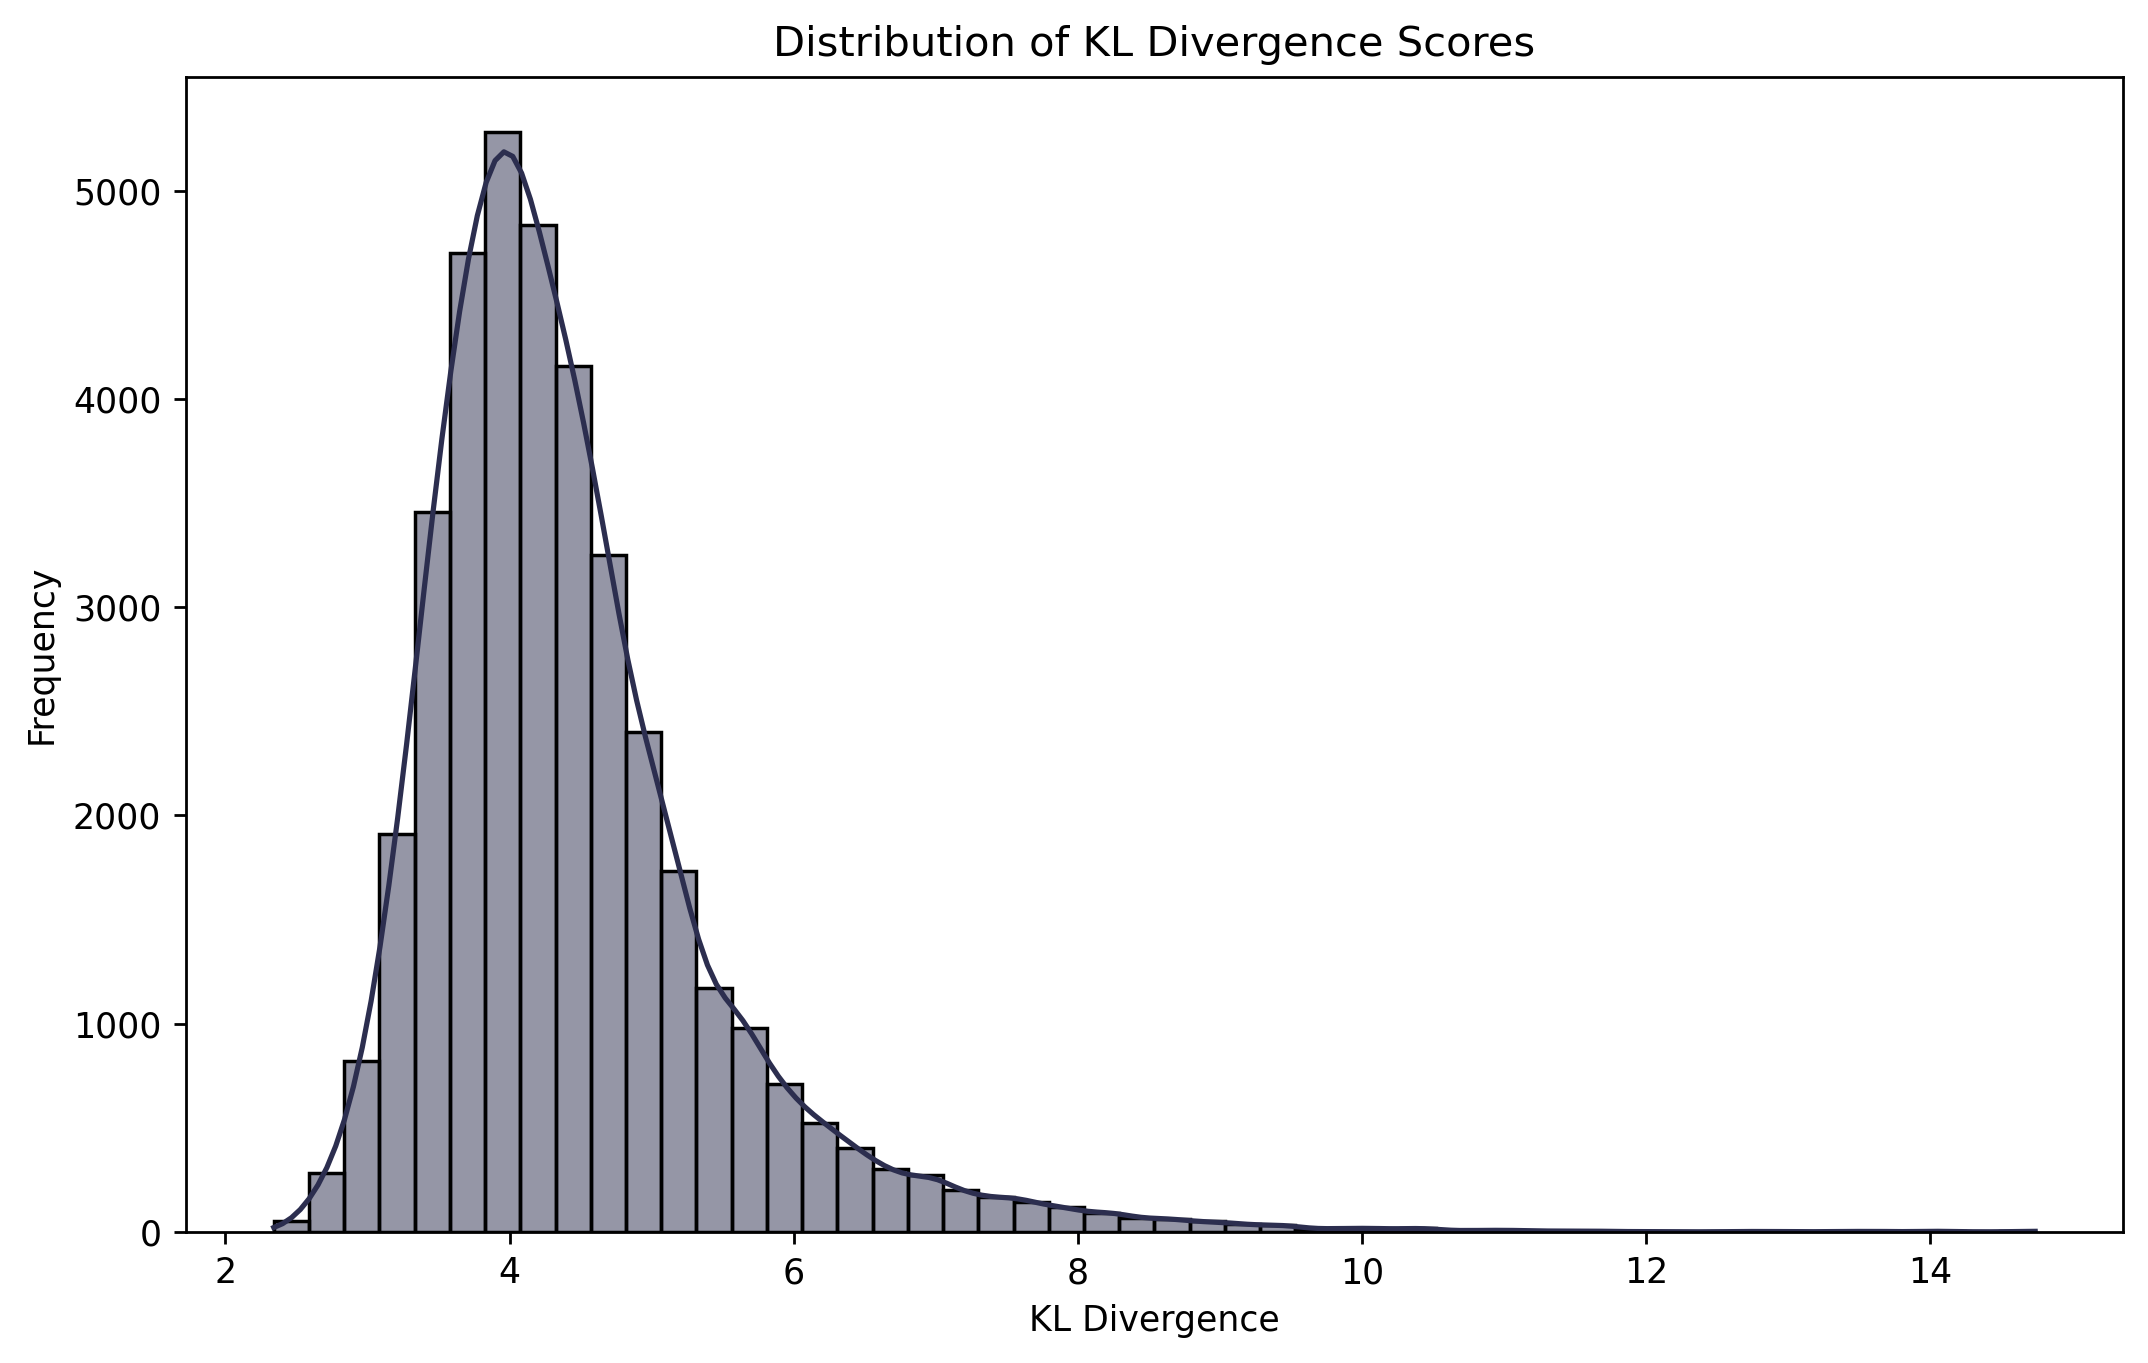

In [38]:
plt.figure(figsize=(10, 6), dpi=250)
sns.histplot(df_top10['kl_divergence'], bins=50, kde=True, color='#2C2E4F')
plt.xlabel('KL Divergence')
plt.ylabel('Frequency')
plt.title('Distribution of KL Divergence Scores')
plt.savefig('kl-top10.png', dpi=250)
plt.show()

<div style='border:2px solid #2C2E4F; padding:15px'>
    The KL divergence scores appear to peak at 4. For core topics, if the goal is to ensure that the LDA model reflects documents that are representative of the overall corpus, it would be advisable to set the threshold at or below 4. This ensures that the selected documents are not too divergent from the overall corpus distribution. Conversely, if the objective is to explore a broader range of topics or identify unique document characteristics, setting the threshold higher than 4 would be beneficial.
</div>

<div style="background-color:#FFDE58 ; padding: 10px 0;">
    <center><h5 style="color:#2C2E4F; font-weight:bold; font-size:15px ">Statistical Outliers in the KL Divergence Scores</h5></center>
</div>

In [39]:
Q1 = df_top10['kl_divergence'].quantile(0.25)
Q3 = df_top10['kl_divergence'].quantile(0.75)
IQR = Q3 - Q1
upper_kl_threshold = Q3 + 1.5 * IQR
lower_kl_threshold = Q1 - 1.5 * IQR

In [40]:
# valid documents
df_top10_filtered = df_top10[(df_top10['kl_divergence'] > lower_kl_threshold) & (df_top10['kl_divergence'] < upper_kl_threshold)]
df_top10_filtered.head()

,collected_at,metadata_event_time,metadata_event_name,metadata_context_id,metadata_context_role,metadata_user_id,body_assignment_id,body_discussion_topic_id,body_discussion_entry_id,body_submission_id,body_user_id,body_parent_discussion_entry_id,body_text,sentences,sentences_joined,preprocessed_text,kl_divergence
15,2021-09-30 16:07:25,2021-09-30 03:33:28.882000+00:00,discussion_entry_created,id_165820000000017181,StudentEnrollment,id_165820000000031411,NaN,topic_477591,entry_1629821,NaN,user_31411,entry_0,"as an ateneo student, i should strive for exce...","['as an ateneo student, i should strive for ex...","as an ateneo student, i should strive for exce...",ateneo student strive excellence academically ...,5.591669
78,2021-09-30 16:07:25,2021-09-30 08:40:57.070000+00:00,discussion_entry_created,id_165820000000015636,StudentEnrollment,id_165820000000013516,NaN,topic_468454,entry_1631403,NaN,user_13516,entry_1631213,hi rie! i liked and agree with how you explain...,['i liked and agree with how you explained the...,i liked and agree with how you explained the r...,like agree explain relationship power dynamic ...,3.937162
79,2021-09-30 16:07:25,2021-09-30 08:47:54.114000+00:00,discussion_entry_created,id_165820000000015636,StudentEnrollment,id_165820000000013592,NaN,topic_468454,entry_1631444,NaN,user_13592,entry_0,"indeed, there is an evident power dynamic betw...","['indeed, there is an evident power dynamic be...","indeed, there is an evident power dynamic betw...",evident power dynamic experimenter participant...,4.012532
100,2021-09-30 16:07:25,2021-09-30 11:19:40.348000+00:00,discussion_entry_created,id_165820000000013932,StudentEnrollment,id_165820000000030161,NaN,topic_410682,entry_1632109,NaN,user_30161,entry_0,"many songs remind me of home, but so far, the ...","[""many songs remind me of home, but so far, th...","many songs remind me of home, but so far, the ...",song remind home far good ben&ben ride home vi...,4.321903
102,2021-09-30 16:07:25,2021-09-30 11:31:39.103000+00:00,discussion_entry_created,id_165820000000013932,StudentEnrollment,id_165820000000030161,NaN,topic_410682,entry_1632157,NaN,user_30161,entry_1555766,"same, i feel you! also, this is one of my favo...","['also, this is one of my favorites songs to s...","also, this is one of my favorites songs to sin...",favorite song sing karaoke know song play,6.220160


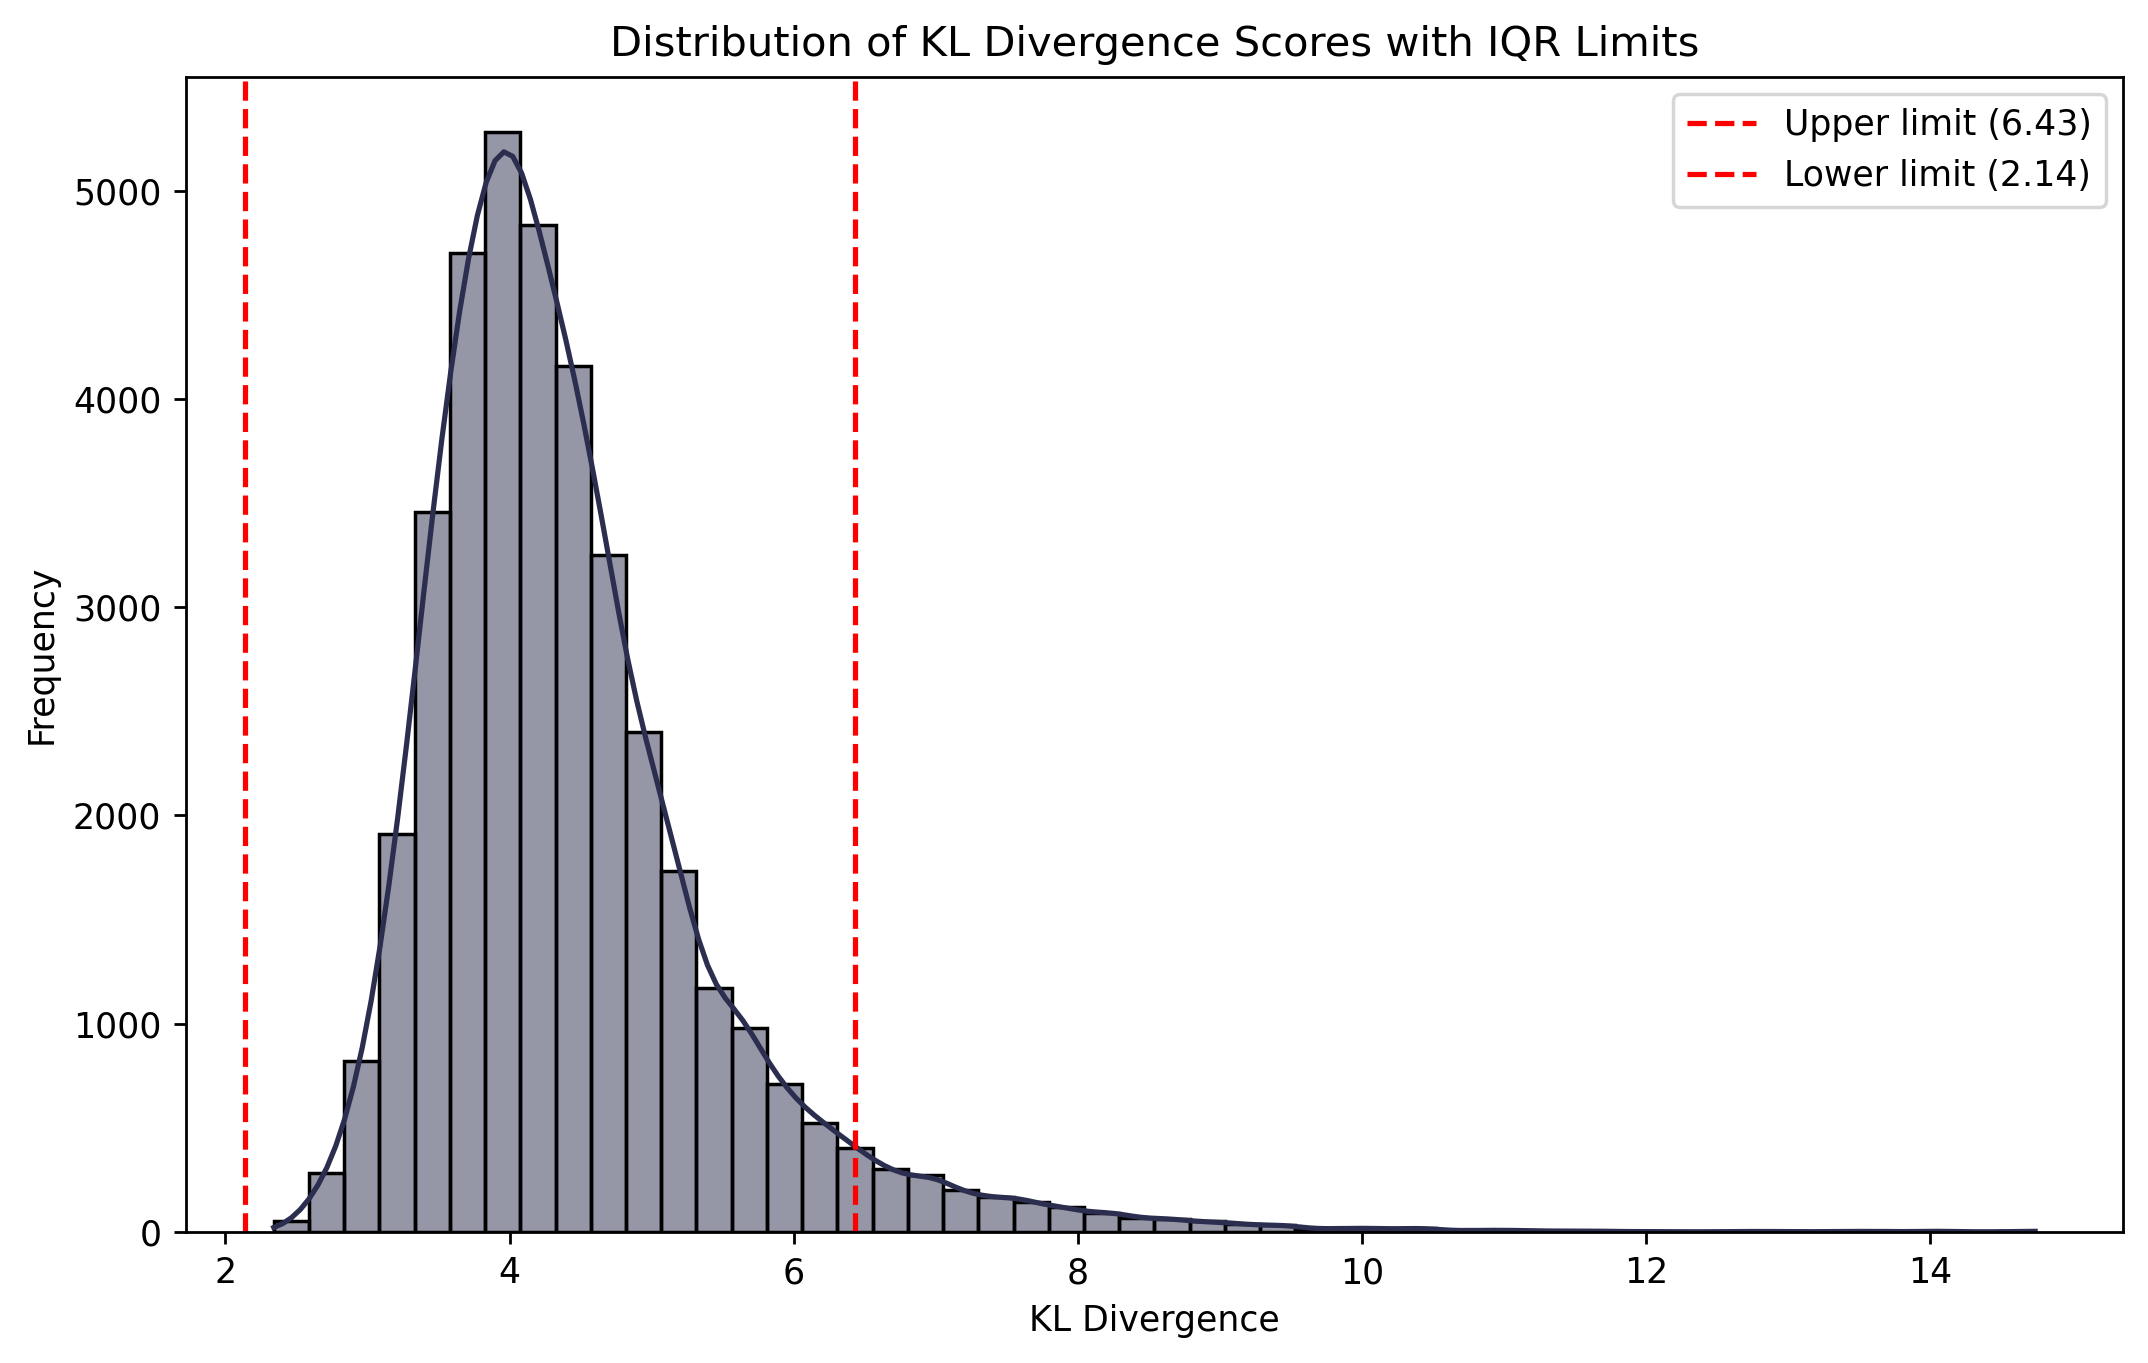

In [41]:
# Plotting the distribution of KL Divergence scores with IQR limits
plt.figure(figsize=(10, 6), dpi=250)
sns.histplot(df_top10['kl_divergence'], bins=50, kde=True, color='#2C2E4F')

# Add vertical lines for upper and lower IQR thresholds
plt.axvline(upper_kl_threshold, color='red', linestyle='--',
            label=f'Upper limit ({upper_kl_threshold:.2f})')
plt.axvline(lower_kl_threshold, color='red', linestyle='--', 
            label=f'Lower limit ({lower_kl_threshold:.2f})')

# Add labels, title, and legend
plt.xlabel('KL Divergence')
plt.ylabel('Frequency')
plt.title('Distribution of KL Divergence Scores with IQR Limits')
plt.legend()

# Save the plot
plt.savefig('kl-top10-with-iqr.png', dpi=250)
plt.show()

<div style='border:2px solid #2C2E4F; padding:15px'>
    A KL divergence score that is close to 0 means that the token distribution of an entry is extremely similar to the token distribution of the entire corpus. Notice that there are no left outliers. We surmise that this is because students in academic platforms have naturally varying writing styles and topic focuses. On the other hand, the cell block below shows the presence of right outliers, indicating that some students produce texts that are either significantly longer or shorter than those of their peers.
</div>

In [42]:
# right outliers
df_right_outliers = df_top10[df_top10['kl_divergence'] > upper_kl_threshold]
print(df_right_outliers.shape[0])
display(df_right_outliers.head())

1836


,collected_at,metadata_event_time,metadata_event_name,metadata_context_id,metadata_context_role,metadata_user_id,body_assignment_id,body_discussion_topic_id,body_discussion_entry_id,body_submission_id,body_user_id,body_parent_discussion_entry_id,body_text,sentences,sentences_joined,preprocessed_text,kl_divergence
56,2021-09-30 16:07:25,2021-09-30 06:37:07.907000+00:00,discussion_entry_created,id_165820000000014432,StudentEnrollment,id_165820000000030779,NaN,topic_458540,entry_1630624,NaN,user_30779,entry_1494207,i couldn't agree more with you as you said tha...,"[""i couldn't agree more with you as you said t...",i couldn't agree more with you as you said tha...,agree say mindset resiliency patriotic spirit ...,6.530146
301,2021-09-30 16:07:30,2021-09-30 12:46:43.890000+00:00,discussion_entry_created,id_165820000000013969,StudentEnrollment,id_165820000000015787,NaN,topic_487512,entry_1632504,NaN,user_15787,entry_1631808,"hi, jose! this is quite a tantalizing insight ...","[""this is quite a tantalizing insight to rollm...",this is quite a tantalizing insight to rollman...,tantalizing insight rollman argument especiall...,6.619508
636,2021-09-30 16:07:36,2021-09-30 08:11:53.292000+00:00,discussion_entry_created,id_165820000000013932,StudentEnrollment,id_165820000000029607,NaN,topic_410682,entry_1631215,NaN,user_29607,entry_1599787,this is so truee,['this is so truee'],this is so truee,truee,14.739338
667,2021-09-30 16:07:36,2021-09-30 11:24:24.135000+00:00,discussion_entry_created,id_165820000000013932,StudentEnrollment,id_165820000000030161,NaN,topic_410682,entry_1632123,NaN,user_30161,entry_1624475,"i first discovered ""you belong with me"" back i...","['i first discovered ""you belong with me"" back...","i first discovered ""you belong with me"" back i...",discover belong day myx play music countdown d...,7.029054
767,2021-09-30 16:07:55,2021-09-30 11:22:08.926000+00:00,discussion_entry_created,id_165820000000013932,StudentEnrollment,id_165820000000030161,NaN,topic_410682,entry_1632114,NaN,user_30161,entry_1631183,"wow, enzo, same! what a coincidence to have th...",['what a coincidence to have the same song in ...,what a coincidence to have the same song in su...,coincidence song succession,9.547565


In [43]:
df_top10_filtered.loc[:, 'preprocessed_text_split'] = df_top10_filtered['preprocessed_text'].str.split()

/var/folders/gv/3889nsr56cq_vfgg78k84_dw0000gn/T/ipykernel_796/988978584.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top10_filtered.loc[:, 'preprocessed_text_split'] = df_top10_filtered['preprocessed_text'].str.split()


In [44]:
# # save filtered doc. this will be used for topic modeling.
# df_top10_filtered.to_csv('df_top10_filtered.csv', index=False)

<div style='border:2px solid #2C2E4F; padding:15px'>
    Use the <code>df_top10_filtered.csv</code> file for the implementation of LDA in the <code>LDA-Implementation.ipynb</code> file.
</div>